In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [18]:
from 과제1 import df_product_category_name_translation, df_products
from 과제2 import merge_oicsr

과제 3: 상품 카테고리별 수요 예측 및 재고 관리 인사이트
시간에 따른 상품 카테고리별 판매 트렌드를 분석하고, 계절성 패턴을 파악하여 향후 수요 예측과 재고 관리 전략을 수립 
merge 

In [ ]:
# 1) products 붙이기
merge_oicsrp = merge_oicsr.merge(
    df_products.drop_duplicates(subset="product_id"),
    on="product_id",
    how="left"
)

# 2) 카테고리 번역 붙이기
merge_oicsrp_cate = merge_oicsrp.merge(
    df_product_category_name_translation.drop_duplicates(subset="product_category_name"),
    on="product_category_name",
    how="left"
)

# 컬럼별 결측치 비율 확인
print("\n=== Null values ===")
print(merge_oicsrp_cate.isnull().sum().sort_values(ascending=False))

df = merge_oicsrp.copy()

# 결측치 처리
df = merge_oicsrp_cate.copy()  

# 1) 날짜/가격 결측 제거
df = df.dropna(subset=["order_purchase_timestamp", "price"])

# 2) 카테고리 결측 라벨링
df["product_category_name_english"] = df["product_category_name_english"].fillna("Unknown")

# 3) 분석용 데이터프레임 확인
print("Rows after cleaning:", df.shape[0])
print("카테고리 결측 처리 후 샘플:")
print(df["product_category_name_english"].value_counts().head())



=== Null values ===
carrier_to_customer              2453
order_delivered_customer_date    2452
product_category_name_english    1626
product_weight_g                 1602
product_photos_qty               1602
product_description_lenght       1602
product_category_name            1602
product_length_cm                1602
product_height_cm                1602
product_name_lenght              1602
product_width_cm                 1602
approved_to_carrier              1209
order_delivered_carrier_date     1194
sample_review_title               941
first_review_date                 941
has_text                          941
review_score_mean                 941
sample_review_message             941
last_review_date                  941
review_count                      941
order_approved_at                  15
purchase_to_approved               15
order_item_id                       0
order_estimated_delivery_date       0
purchase_to_estimated               0
order_id                     

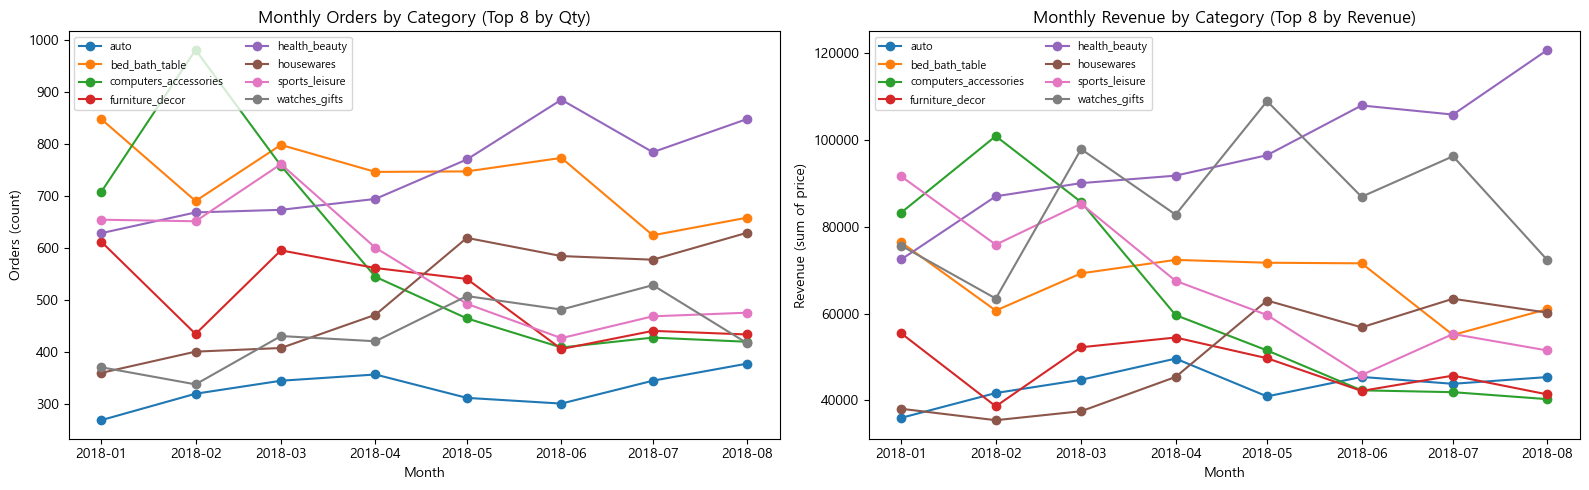

In [44]:
# 1) 월 단위 컬럼 생성
df["month"] = df["order_purchase_timestamp"].values.astype("datetime64[M]")
df["qty"] = 1  # 각 row = 1개 주문 아이템

# 2) 월별 카테고리별 판매량 / 매출 집계
monthly_cat = (
    df.groupby(["month", "product_category_name_english"], as_index=False)
      .agg(qty=("qty", "sum"),
           revenue=("price", "sum"))
      .sort_values(["month", "product_category_name_english"])
)

# 3) Top-N 카테고리 선정 (전체 기간 기준)
N = 8
topN_qty = (monthly_cat.groupby("product_category_name_english")["qty"]
                        .sum().sort_values(ascending=False).head(N).index.tolist())
topN_rev = (monthly_cat.groupby("product_category_name_english")["revenue"]
                        .sum().sort_values(ascending=False).head(N).index.tolist())

# 4) Pivot (판매량 & 매출)
pivot_qty = (monthly_cat[monthly_cat["product_category_name_english"].isin(topN_qty)]
             .pivot(index="month", columns="product_category_name_english", values="qty")
             .fillna(0))

pivot_rev = (monthly_cat[monthly_cat["product_category_name_english"].isin(topN_rev)]
             .pivot(index="month", columns="product_category_name_english", values="revenue")
             .fillna(0))

# 5) 시각화 (1줄에 2개 그래프)
fig, axes = plt.subplots(1, 2, figsize=(16,5))

# (왼쪽) 판매량
for col in pivot_qty.columns:
    axes[0].plot(pivot_qty.index, pivot_qty[col], marker="o", label=col)
axes[0].set_title(f"Monthly Orders by Category (Top {N} by Qty)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Orders (count)")
axes[0].legend(loc="upper left", ncol=2, fontsize=8)

# (오른쪽) 매출액
for col in pivot_rev.columns:
    axes[1].plot(pivot_rev.index, pivot_rev[col], marker="o", label=col)
axes[1].set_title(f"Monthly Revenue by Category (Top {N} by Revenue)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Revenue (sum of price)")
axes[1].legend(loc="upper left", ncol=2, fontsize=8)

plt.tight_layout()
plt.show()


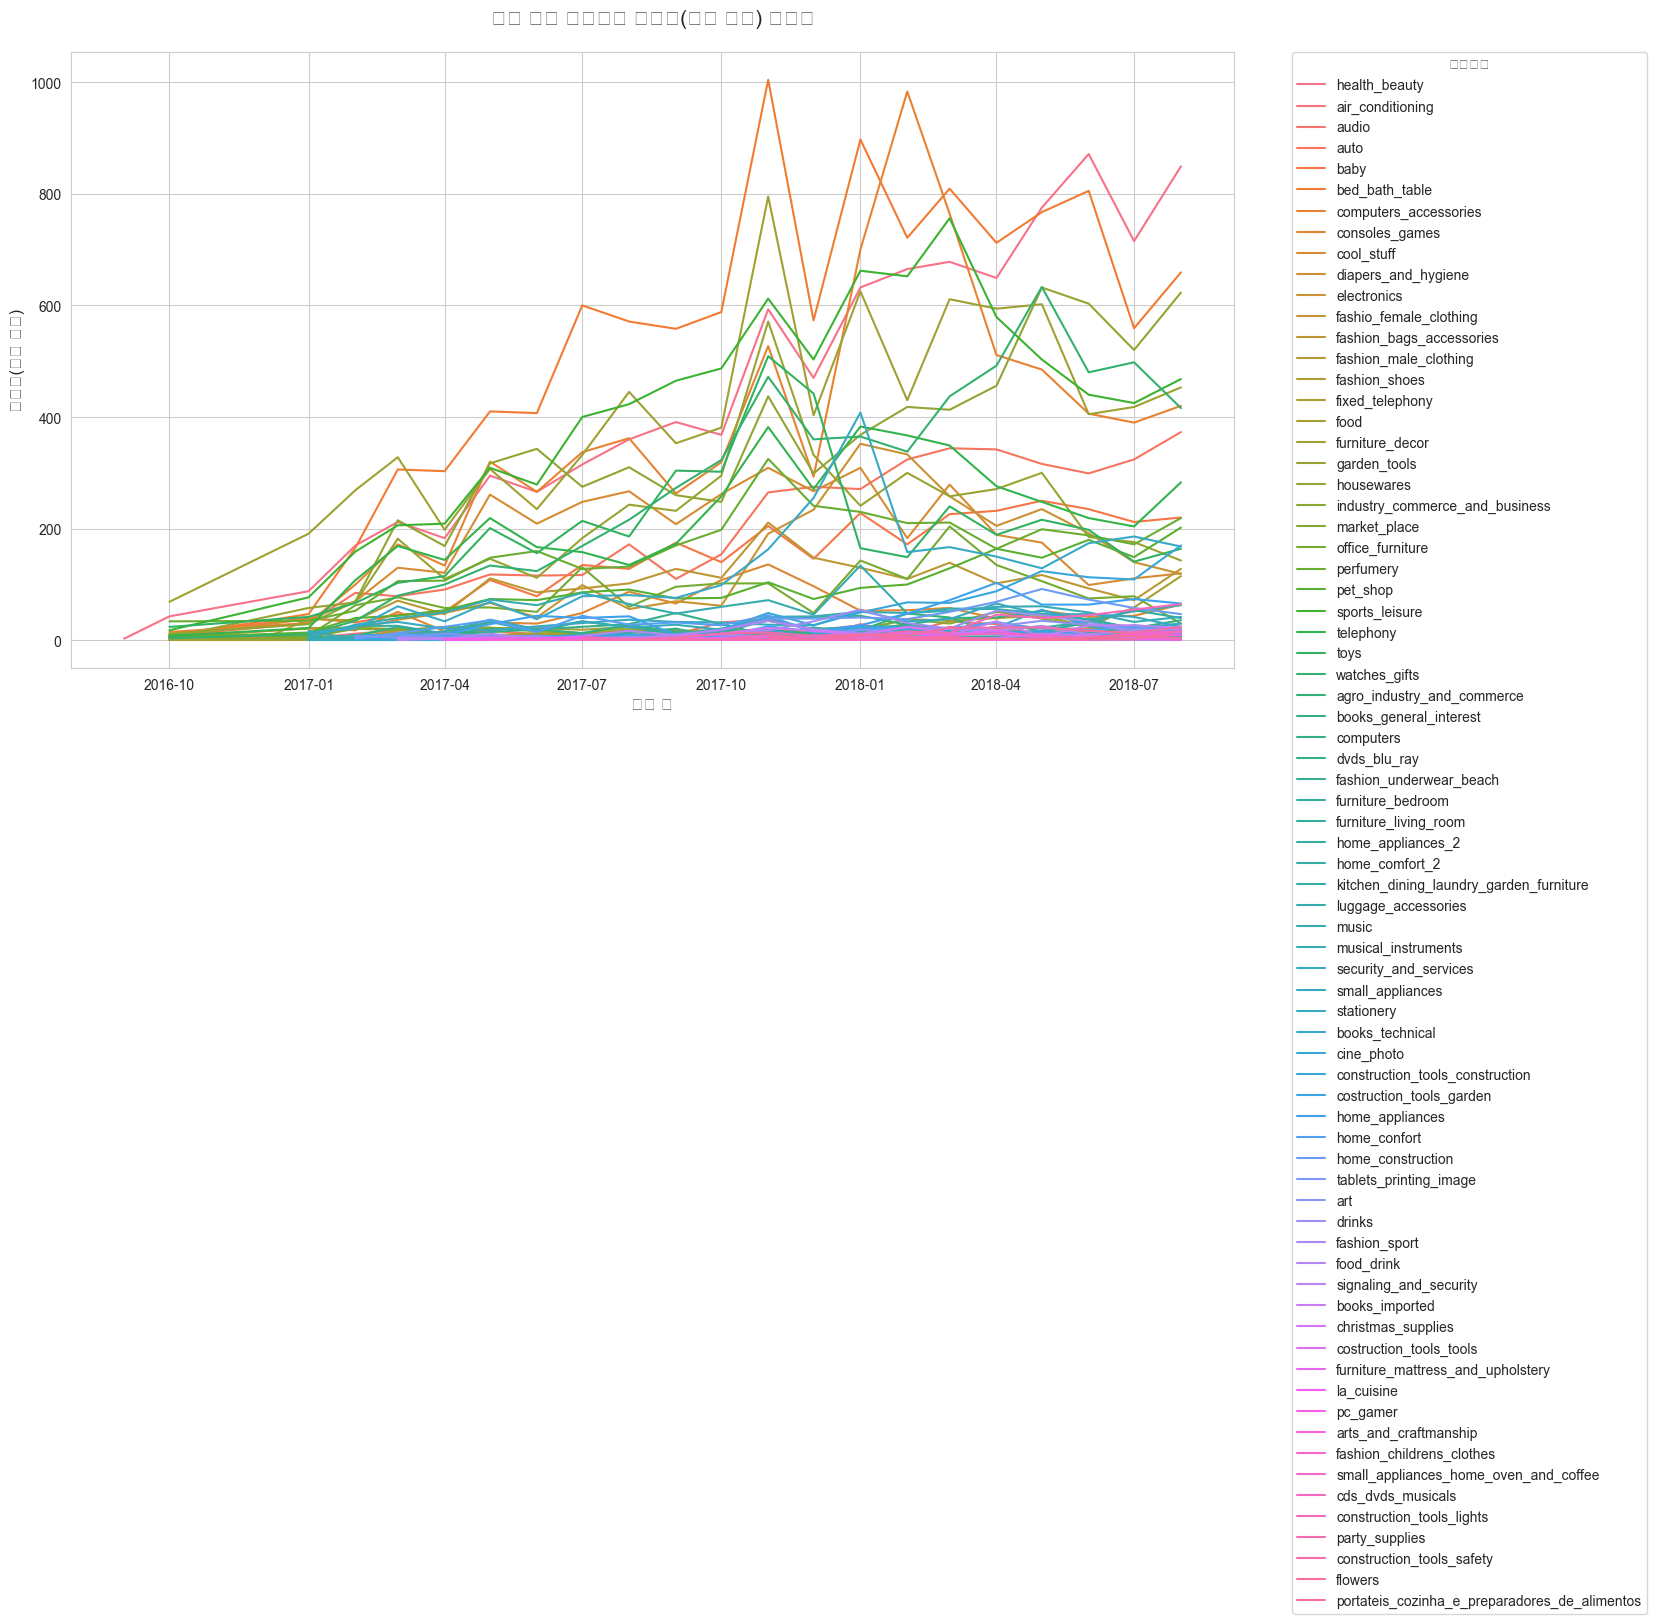

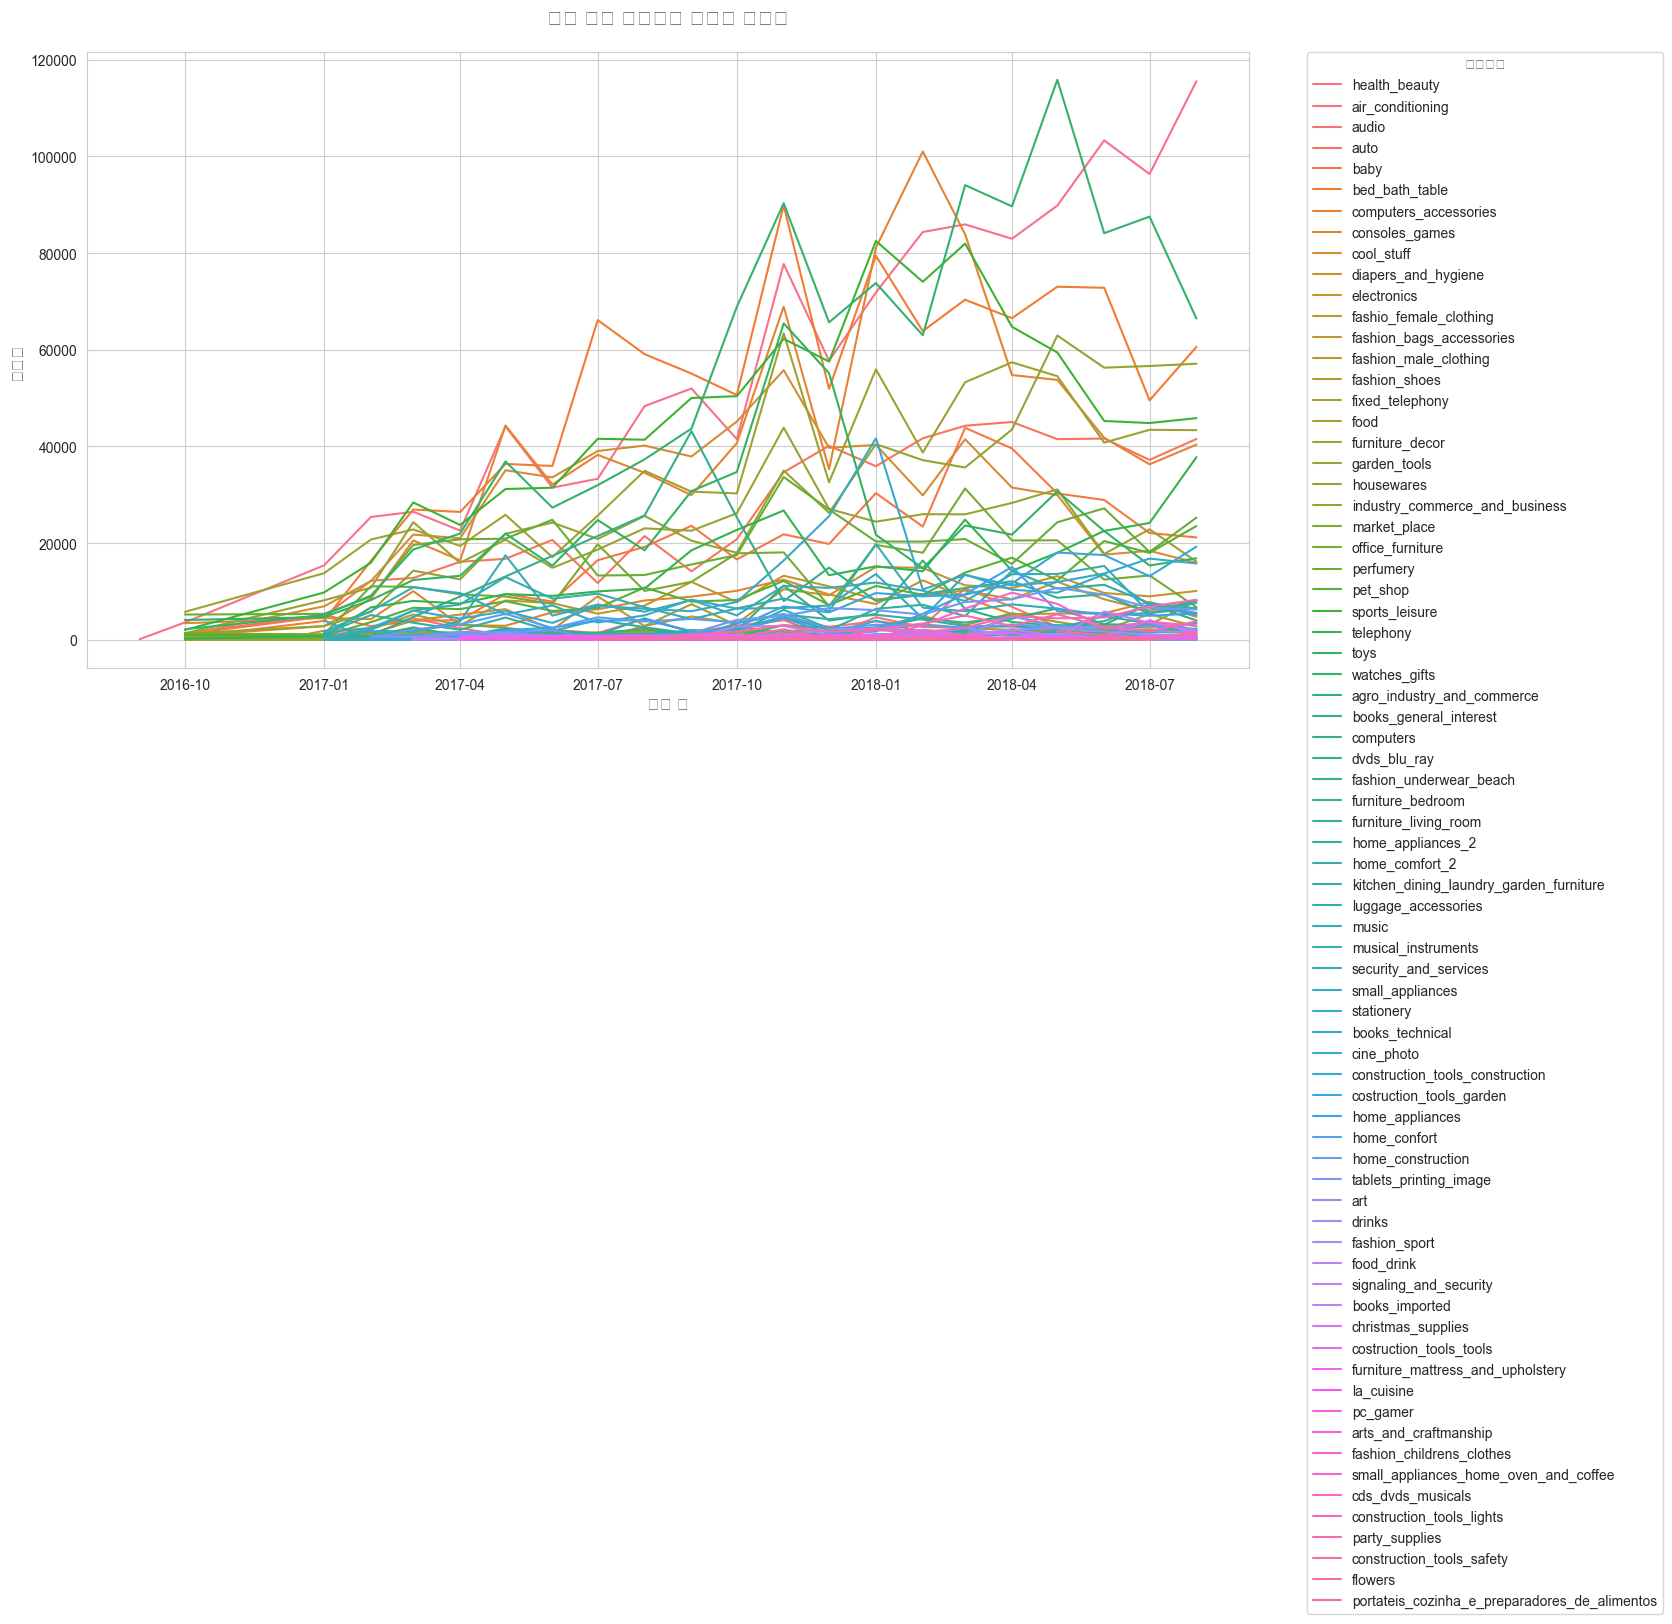

C:\Users\mumu1\AppData\Local\Temp\ipykernel_18848\1937835989.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


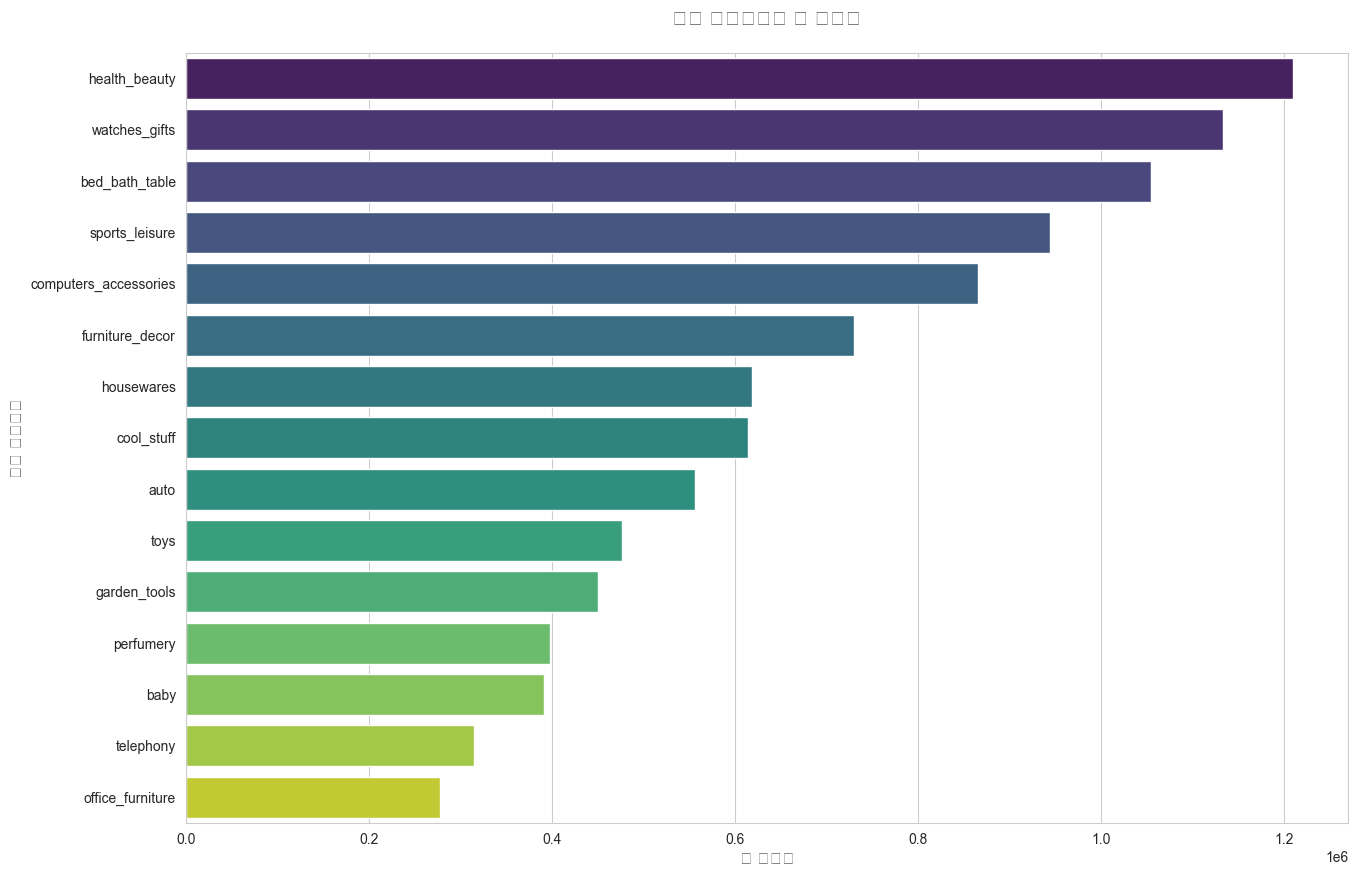

In [ ]:

# 바 그래프 시각화
# 카테고리별 총 매출액 계산 (category_trend_sales 데이터프레임 사용)
# `product_category_name_english`별로 `sales_value`의 합계를 계산
category_total_sales = category_trend_sales.groupby("product_category_name_english")["sales_value"].sum().reset_index()

# 매출액이 높은 순서로 정렬
category_total_sales = category_total_sales.sort_values(by="sales_value", ascending=False)

# 바 그래프 시각화
plt.figure(figsize=(15, 10))
sns.barplot(
    data=category_total_sales.head(15), # 상위 15개 카테고리만 시각화
    x="sales_value",
    y="product_category_name_english",
    palette="viridis" # 색상 팔레트 지정
)
plt.title("상품 카테고리별 총 매출액", fontsize=15, pad=20)
plt.xlabel("총 매출액", fontsize=12)
plt.ylabel("상품 카테고리", fontsize=12)
plt.show()


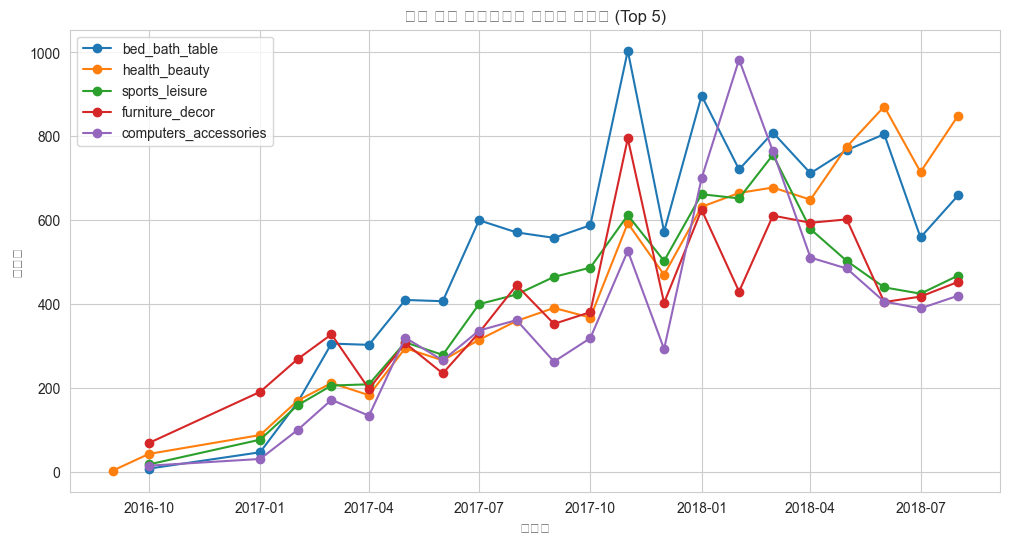

In [11]:
# 특정 인기 카테고리 몇 개만 선택 (예: 상위 5개)
top_categories = (
    category_trend_qty.groupby("product_category_name_english")["sales_qty"]
    .sum()
    .nlargest(5)
    .index
)

plt.figure(figsize=(12,6))

for cat in top_categories:
    subset = category_trend_qty[category_trend_qty["product_category_name_english"] == cat]
    plt.plot(subset["order_month"], subset["sales_qty"], marker="o", label=cat)

plt.title("월별 상품 카테고리별 판매량 트렌드 (Top 5)")
plt.xlabel("주문월")
plt.ylabel("판매량")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
merge_full.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,...,payment_type,payment_installments,payment_value,order_item_id,seller_id,shipping_limit_date,price,freight_value,outlier_flag,order_month
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,...,debit_card,1.0,18.30,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,1,2018-04-01
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,...,voucher,1.0,265.99,1,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99,1,2018-01-01
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,...,credit_card,1.0,87.62,1,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82,1,2018-07-01
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,...,credit_card,2.0,121.84,1,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54,1,2018-08-01
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,...,credit_card,4.0,46.19,1,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29,1,2018-04-01


In [13]:
'''월·카테고리 집계 생성(판매량/매출),
계절 지표 산출(월별 시즌 인덱스, STL 기반 계절성 강도, ACF@12, 비모수 검정),
상위 카테고리 시계열·ACF·STL 구성요소·월-오브-이어 히트맵 시각화,
강한 계절 카테고리 자동 리포트.'''

# ===== 기본 점검 =====
required_cols = {
    'product_category_name_english',
    'order_month',               # datetime64[ns], 월 첫째날이면 베스트
    'price',                     # 매출 계산용
    'order_item_id'              # Olist 구조에서 '수량' 대용 (행==아이템)
}
missing = required_cols - set(merge_full.columns)
assert len(missing)==0, f"다음 컬럼이 필요합니다: {missing}"

# ===== 1) 월·카테고리 집계 =====
def make_monthly(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['order_month'] = pd.to_datetime(out['order_month']).dt.to_period('M').dt.start_time
    g = out.groupby(['order_month','product_category_name_english'], as_index=False)
    monthly = g.agg(items=('order_item_id','count'),
                    revenue=('price','sum'))
    return monthly.sort_values(['product_category_name_english','order_month'])

monthly_cat = make_monthly(merge_full)

date_min = monthly_cat['order_month'].min()
date_max = monthly_cat['order_month'].max()
print(f"[기간] {date_min.date()} ~ {date_max.date()}")
print(monthly_cat.head())


[기간] 2016-09-01 ~ 2018-08-01
    order_month product_category_name_english  items  revenue
31   2017-01-01    agro_industry_and_commerce      3    65.97
73   2017-02-01    agro_industry_and_commerce      9   268.82
122  2017-03-01    agro_industry_and_commerce      2    81.99
231  2017-05-01    agro_industry_and_commerce      4  1579.94
290  2017-06-01    agro_industry_and_commerce      1   890.00


In [14]:
# 2) 계절성 측정 도구(시즌 인덱스, STL 강도, ACF@12, Kruskal 검정)
# 카테고리별 시계열 시리즈 생성(빈 달은 0으로 채움)
def series_by_category(monthly, category, metric='items'):
    idx = pd.date_range(monthly['order_month'].min(),
                        monthly['order_month'].max(), freq='MS')
    s = (monthly[monthly['product_category_name_english']==category]
         .set_index('order_month')[metric]
         .reindex(idx, fill_value=0))
    s.index.name = 'order_month'
    return s

# 월-오브-이어(1~12월) 시즌 인덱스: 해당 월 평균 / 전체 평균
def seasonal_index_moy(s: pd.Series) -> pd.Series:
    df = s.to_frame('y')
    df['month'] = df.index.month
    moy = df.groupby('month')['y'].mean()
    overall = df['y'].mean()
    idx = (moy / overall).rename('seasonal_index')
    return idx  # 1.0=평균, 1.2=해당 월이 평균 대비 +20%

# STL 기반 계절성 강도(Hyndman): 1 - Var(resid)/Var(seasonal+resid)
def seasonal_strength_via_stl(s: pd.Series, period=12):
    res = STL(s, period=period, robust=True).fit()
    resid_var = np.var(res.resid, ddof=1)
    season_resid_var = np.var(res.seasonal + res.resid, ddof=1)
    strength = max(0.0, 1.0 - (resid_var / season_resid_var)) if season_resid_var>0 else 0.0
    return float(strength), res

# 월(1~12) 간 분포 차이 비모수 검정(계절성 존재 여부의 보조 지표)
def month_kruskal(s: pd.Series):
    df = s.to_frame('y')
    df['month'] = df.index.month
    groups = [g['y'].values for _, g in df.groupby('month')]
    if len(groups)<2: 
        return np.nan, np.nan
    stat, p = kruskal(*groups)
    return float(stat), float(p)

# 카테고리 요약 리포트 생성
def build_seasonality_report(monthly, categories, metric='items'):
    rows = []
    for cat in categories:
        s = series_by_category(monthly, cat, metric)
        if len(s) < 18:  # 최소 18개월 권장
            continue
        strength, stl_res = seasonal_strength_via_stl(s, period=12)
        idx = seasonal_index_moy(s)
        peak_month = int(idx.idxmax())   # 1~12
        trough_month = int(idx.idxmin())
        peak_trough_ratio = float(idx.max()/idx.min()) if idx.min()>0 else np.nan
        acf_vals = acf(s, nlags=24, fft=False)
        acf12 = float(acf_vals[12]) if len(acf_vals) > 12 else np.nan
        stat, p = month_kruskal(s)

        rows.append({
            'category': cat,
            'metric': metric,
            'n_months': int(len(s)),
            'seasonal_strength_STL': strength,
            'acf_lag12': acf12,
            'kruskal_p': p,
            'peak_month': peak_month,
            'trough_month': trough_month,
            'peak/trough_ratio': peak_trough_ratio
        })
    rep = pd.DataFrame(rows)
    if not rep.empty:
        rep = rep.sort_values(['seasonal_strength_STL','acf_lag12'], ascending=False)
    return rep
